## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import heapq

## BirdFlockSimulator

In [2]:
class NearestNeighbourCalculator:

  # Heap for NN
  class KHeap():
    def __init__(self, capacity):
      self.capacity = capacity
      self.data = []

    def push(self, elem):
      elem[0] = -elem[0]
      if len(self.data) < self.capacity:
        heapq.heappush(self.data, elem)
      elif elem > self.data[0]:
        heapq.heappop(self.data)
        heapq.heappush(self.data, elem)
  
  def __init__(self, neighBoursN):
    self.neighboursN = neighBoursN
  
  def getNNDf(self, df):
    res = []
    for i in range(len(df)):
      res.append(self.getKNearestNeighbours(i, df))
    nndf = pd.DataFrame(np.array(res))
    nndf = nndf.rename(mapper=self.mapColNames, axis='columns')
    return pd.concat([df, nndf], axis='columns')

  # Nearest Neighbours
  def getKNearestNeighbours(self, i, df):
    bird = df.iloc[i]
    h = self.KHeap(self.neighboursN)
    for index, row in df.iterrows():
      if i == index:
        continue
      dist = abs(row.x-bird.x) ** 2 + abs(row.y-bird.y) ** 2
      h.push([dist, row])
    h.data.sort()
    return np.array(
      [[math.sqrt(-x[0]), x[1][0], x[1][1]]
      for x in reversed(h.data)]).flatten()

  def mapColNames(self, col):
    nnn = col//3
    label = ""
    if col % 3 == 0:
      label = "dist"
    elif col % 3 == 1:
      label = "x"
    else:
      label = "y"
    return f"nn_{nnn}_{label}"
  

In [3]:
class VectorCalculator:
  def __init__(self, neighBoursN):
    self.neighboursN = neighBoursN

  # Vector calculation
  def getVectors(self, df):
    # Calculate vector based on NN
    vectorData = []
    for index, row in df.iterrows():
      newXVector = 0.0
      newYVector = 0.0
      for i in range(self.neighboursN):
        xDiff, yDiff = self.calcVector(row, (row[f"nn_{i}_x"], row[f"nn_{i}_y"], row[f"nn_{i}_dist"]))
        newXVector += xDiff
        newYVector += yDiff
      xVector = newXVector + row.vx
      yVector = newYVector + row.vy
      # Take vectors and combine with current velocity
      vectorData.append(np.array([xVector, yVector]))
    ret = pd.DataFrame(np.array(vectorData))
    ret.columns = ["x", "y"]
    return ret
  
  # Alternative, use the vectors of the 5 closest neightbours instead?
  def calcVector(self, bird, neighbour):
    neighbourX, neighbourY, neighbourDist = neighbour
    vecX = neighbourX-bird.x
    vecY = neighbourY-bird.y
    # If neighbour is greater than 15, we want to be attracted to a point 10 away
    if neighbourDist >= 15:
      attraction = neighbourDist-10
      attractionFactor = 0.1
      return self.normalizeVector(vecX, vecY, attraction*attractionFactor)
    # If neighbour is less than 10, repulse them based on how close they are
    # Push away linearly
    elif neighbourDist <= 5:
      repulsion = 10-neighbourDist
      repulsionFactor = 0.1
      return self.normalizeVector(-vecX, -vecY, repulsion*repulsionFactor)
    # Else, maintain current vector
    else:
      return (0, 0)
  
  def normalizeVector(self, x, y, scale=1):
    hyp = math.sqrt(x**2 + y**2)
    return ((x/hyp)*scale, (y/hyp)*scale)

In [4]:
class BirdFlockSimulator:

  # Init
  def __init__(self, numBirds):
    self.numBirds = numBirds
    self.maxX = 100
    self.maxY = 100
    self.neighboursN = 5
    self.birds = self.createBirdsDataframe()

  def createBirdsDataframe(self):
    d = {
      'x': np.random.rand(self.numBirds) * self.maxX,
      'y': np.random.rand(self.numBirds) * self.maxY,
      'vx' : np.random.rand(self.numBirds) * 10,
      'vy' : np.random.rand(self.numBirds) * 10
    }
    return pd.DataFrame(data=d)

  def tick(self):
    # NN
    nnCalc = NearestNeighbourCalculator(self.neighboursN)
    nnDf = nnCalc.getNNDf(self.birds)

    # Vectors
    vCalc = VectorCalculator(self.neighboursN)
    vectors = vCalc.getVectors(nnDf)

    # Create new df
    newD = self.birds[['x', 'y']] + vectors
    vectors.columns = ['vx', 'vy']
    self.birds = pd.concat([newD, vectors], axis=1)

  def getDf(self):
    return self.birds

  

## Test

In [5]:
sim = BirdFlockSimulator(100)

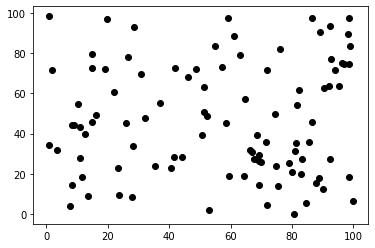

In [6]:
curr = sim.getDf()
plt.plot(curr.x, curr.y, 'o', color='black')

In [7]:
curr

,x,y,vx,vy
0,88.884719,17.834966,0.926846,7.959298
1,31.986539,47.833032,3.108443,9.077168
2,82.964820,19.788056,7.393443,8.510063
3,57.048788,73.162901,0.411536,2.041046
4,68.678717,27.295205,1.287799,9.218518
...,...,...,...,...
95,92.519562,27.533971,7.738318,0.748193
96,28.142960,34.062557,4.627585,4.208010
97,8.312693,14.522406,4.421882,3.772546
98,75.585221,13.961603,2.873628,5.352939


In [8]:
for i in range(10):
  sim.tick()

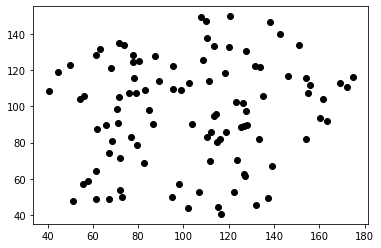

In [9]:
curr = sim.getDf()
plt.plot(curr.x, curr.y, 'o', color='black')

In [12]:
for i in range(30):
  sim.tick()

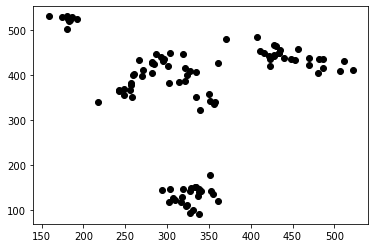

In [13]:
curr = sim.getDf()
plt.plot(curr.x, curr.y, 'o', color='black')